In [1]:
import copy

import prody
from rdkit import Chem
from rdkit.Chem import Draw

from rgroup import rep2D, draw3D, merge_R_group

In [2]:
# load the complex with the ligand
sys = prody.parsePDB('5NEV.pdb1')
rec = sys.select('not (nucleic or hetatm) and not water')
mol = sys.select('resname 72L')

prody.writePDB('rec.pdb', rec)
prody.writePDB('lig.pdb', mol)

@> 4485 atoms and 1 coordinate set(s) were parsed in 0.04s.


'lig.pdb'

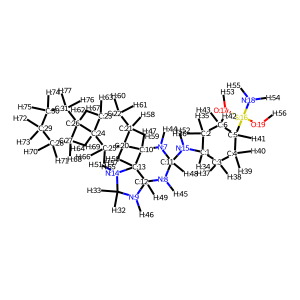

In [3]:
# load the ligand
mol = Chem.MolFromPDBFile('lig.pdb')
mol = Chem.AddHs(mol, addCoords=True)

# select the atom to be replaced with the R group
Draw.MolToImage(rep2D(mol))

In [4]:
# load the R group
R_group = Chem.MolFromMolFile('data/rgroups/molecules/alcohols/methanol-r.mol', removeHs=False)
draw3D(mol)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
newMol = merge_R_group(mol, R_group, 72)
draw3D(newMol)

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f2761bf7bc0> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f2761bf7ad0>


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

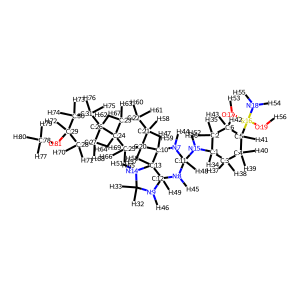

In [6]:
Draw.MolToImage(rep2D(newMol))

In [7]:
result = get_props(newMol)

NameError: name 'get_props' is not defined